# Demos: Lecture 19

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Demo 1: bit flip code

In [2]:
dev = qml.device("default.mixed", wires=3)

In [3]:
def prepare_state(wires):
    #qml.RY(np.pi/3, wires=wires)
    qml.Identity(wires=0)
    
def encode_bit_flip(wires):
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[0], wires[2]])

def detect_and_recover_bit_flip(wires):
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.Toffoli(wires=wires[::-1])

@qml.qnode(dev)
def bit_flip_code(bit_to_flip=None):
    prepare_state(wires=0)
    encode_bit_flip(wires=dev.wires)
    if bit_to_flip is not None:
        qml.PauliX(wires=bit_to_flip)
    detect_and_recover_bit_flip(dev.wires)
    return qml.state()

(<Figure size 1000x400 with 1 Axes>, <Axes: >)

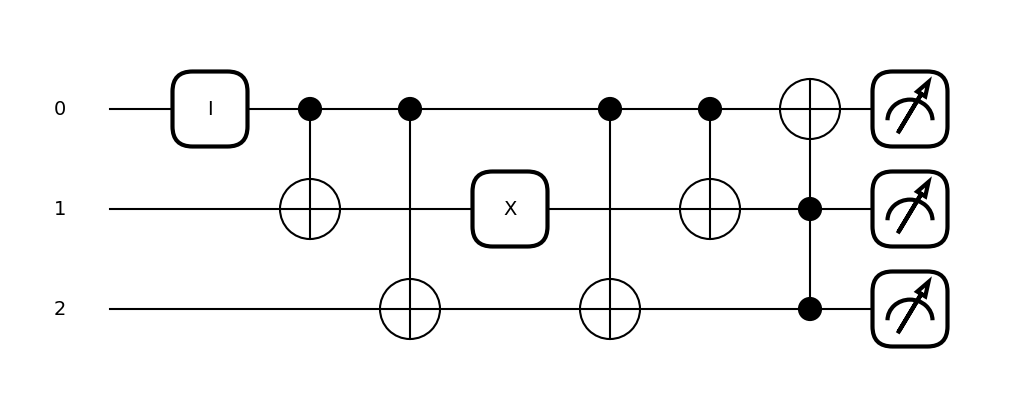

In [4]:
qml.draw_mpl(bit_flip_code)(bit_to_flip=1)

In [5]:
qml.math.partial_trace(bit_flip_code(1), indices=[1, 2])

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

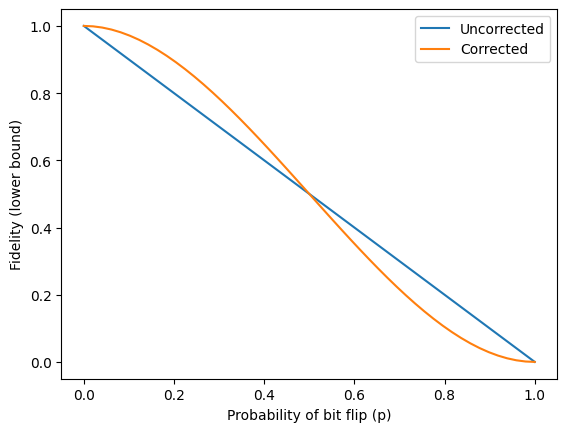

In [6]:
p_values = np.linspace(0., 1, 50)

plt.plot(p_values, 1 - p_values, label="Uncorrected")
plt.plot(p_values, (1 - p_values) ** 3 + 3 * p_values * (1 - p_values) ** 2, label="Corrected")
plt.xlabel("Probability of bit flip (p)")
plt.ylabel("Fidelity (lower bound)")
plt.legend()

## Demo 2: logical operations

In [7]:
def logical_x(wires):
    for wire in wires:
        qml.PauliX(wires=wire)

def logical_z(wires):
    qml.PauliZ(wires=wires[0])

def logical_hadamard(wires):
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[0], wires[2]])

@qml.qnode(dev)
def bit_flip_logical(logical_op, bit_to_flip=None):    
    encode_bit_flip(dev.wires)

    logical_x(dev.wires)
    logical_op(dev.wires)

    # Inserting an error
    if bit_to_flip is not None:
        qml.PauliX(wires=bit_to_flip)
    
    detect_and_recover_bit_flip(dev.wires)
    
    return qml.state()

In [8]:
qml.math.partial_trace(bit_flip_logical(logical_hadamard), indices=[1, 2])

array([[ 0.5+0.j, -0.5+0.j],
       [-0.5+0.j,  0.5+0.j]])

In [9]:
def logical_cnot(wires_ctrl, wires_targ):
    for ctrl, targ in zip(wires_ctrl, wires_targ):
        qml.CNOT(wires=[ctrl, targ])

dev = qml.device("default.mixed", wires=6)

ctrl_wires = dev.wires[:3]
targ_wires = dev.wires[3:]

@qml.qnode(dev)
def apply_logical_cnot(bit_to_flip=None):
    encode_bit_flip(ctrl_wires)
    encode_bit_flip(targ_wires)
    
    logical_x(wires=ctrl_wires)
    logical_cnot(ctrl_wires, targ_wires)

    # Inserting an error
    if bit_to_flip is not None:
        qml.PauliX(wires=bit_to_flip)

    detect_and_recover_bit_flip(ctrl_wires)
    detect_and_recover_bit_flip(targ_wires)
    
    return qml.probs(wires=[ctrl_wires[0], targ_wires[0]])

(<Figure size 1300x700 with 1 Axes>, <Axes: >)

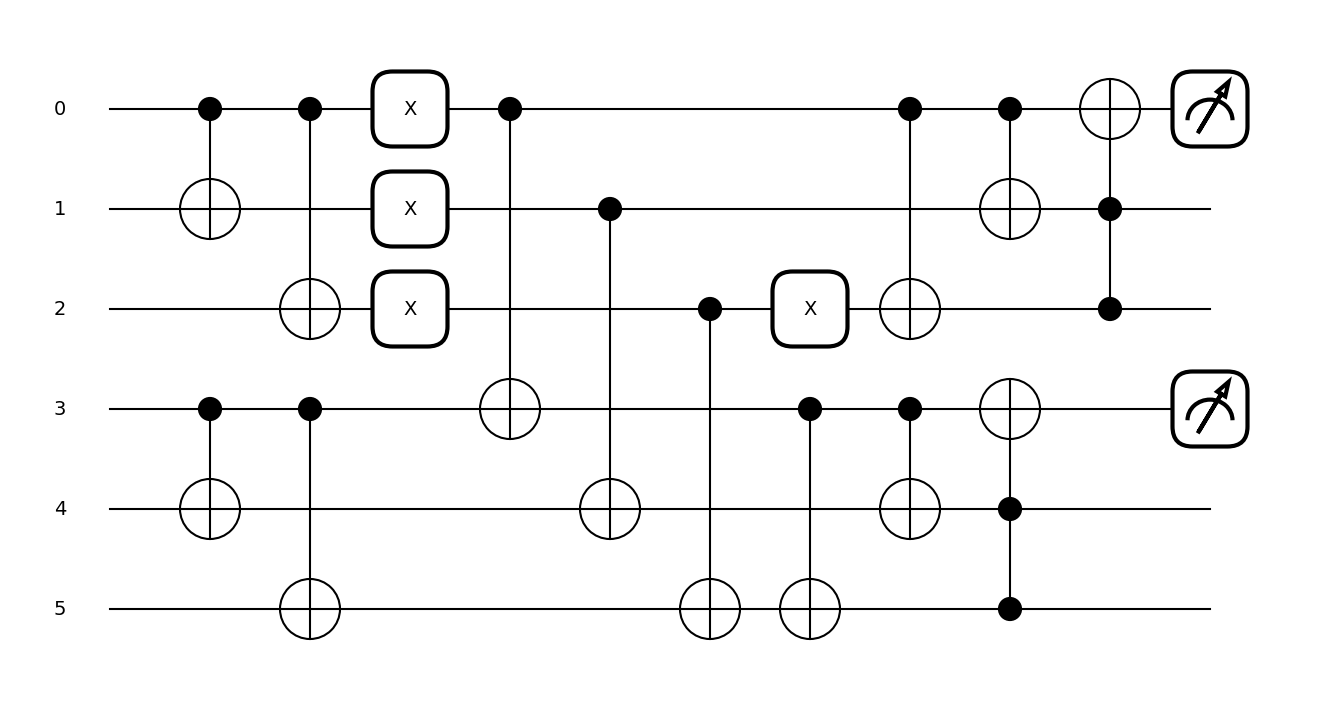

In [10]:
qml.draw_mpl(apply_logical_cnot)(2)

In [11]:
apply_logical_cnot(bit_to_flip=5)

array([0., 0., 0., 1.])

## Demo 3: phase flip code

In [12]:
def prepare_state(wires):
    #qml.RY(np.pi/3, wires=wires)
    qml.Hadamard(wires=0)
    #qml.PauliX(wires=0)

def encode_phase_flip(wires):
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[0], wires[2]])
    for wire in wires:
        qml.Hadamard(wires=wire)

def detect_and_recover_phase_flip(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.Toffoli(wires=wires[::-1])

dev = qml.device("default.mixed", wires=3)

@qml.qnode(dev)
def phase_flip_code(phase_to_flip=None):
    prepare_state(wires=0)
    encode_phase_flip(wires=dev.wires)
    if phase_to_flip is not None:
        qml.PauliZ(wires=phase_to_flip)
    detect_and_recover_phase_flip(dev.wires)
    return qml.state()

(<Figure size 1200x400 with 1 Axes>, <Axes: >)

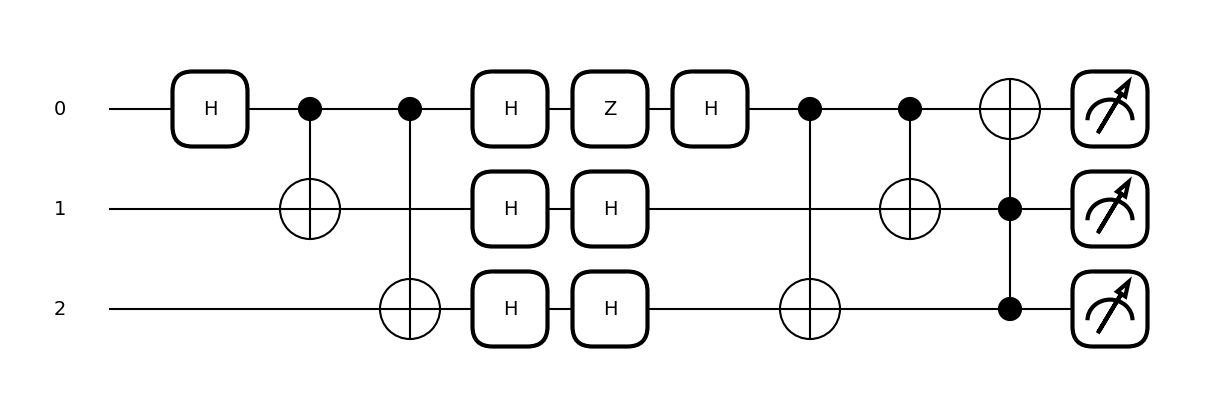

In [13]:
qml.draw_mpl(phase_flip_code)(0)

In [14]:
qml.math.partial_trace(phase_flip_code(0), indices=[1, 2])

array([[0.5+0.j, 0.5+0.j],
       [0.5+0.j, 0.5+0.j]])

## Demo 4: Shor 9-qubit code

In [15]:
def prepare_state(wires):
    qml.RY(np.pi/3, wires=wires)
    #qml.Hadamard(wires=0)

def encode_shor(wires):
    encode_phase_flip([wires[0], wires[3], wires[6]])
    encode_bit_flip(wires[:3])
    encode_bit_flip(wires[3:6])
    encode_bit_flip(wires[6:])

def detect_and_recover_shor(wires):
    detect_and_recover_bit_flip(wires[:3])
    detect_and_recover_bit_flip(wires[3:6])
    detect_and_recover_bit_flip(wires[6:])
    detect_and_recover_phase_flip([wires[0], wires[3], wires[6]])


dev = qml.device("default.mixed", wires=9)

@qml.qnode(dev)
def shor_code(bit_to_flip=None, phase_to_flip=None):
    prepare_state(wires=0)
    
    encode_shor(wires=dev.wires)

    # Errors
    if bit_to_flip is not None:
        qml.PauliX(wires=bit_to_flip)
    if phase_to_flip is not None:
        qml.PauliZ(wires=phase_to_flip)
    
    detect_and_recover_shor(dev.wires)
    return qml.state()

(<Figure size 1600x1000 with 1 Axes>, <Axes: >)

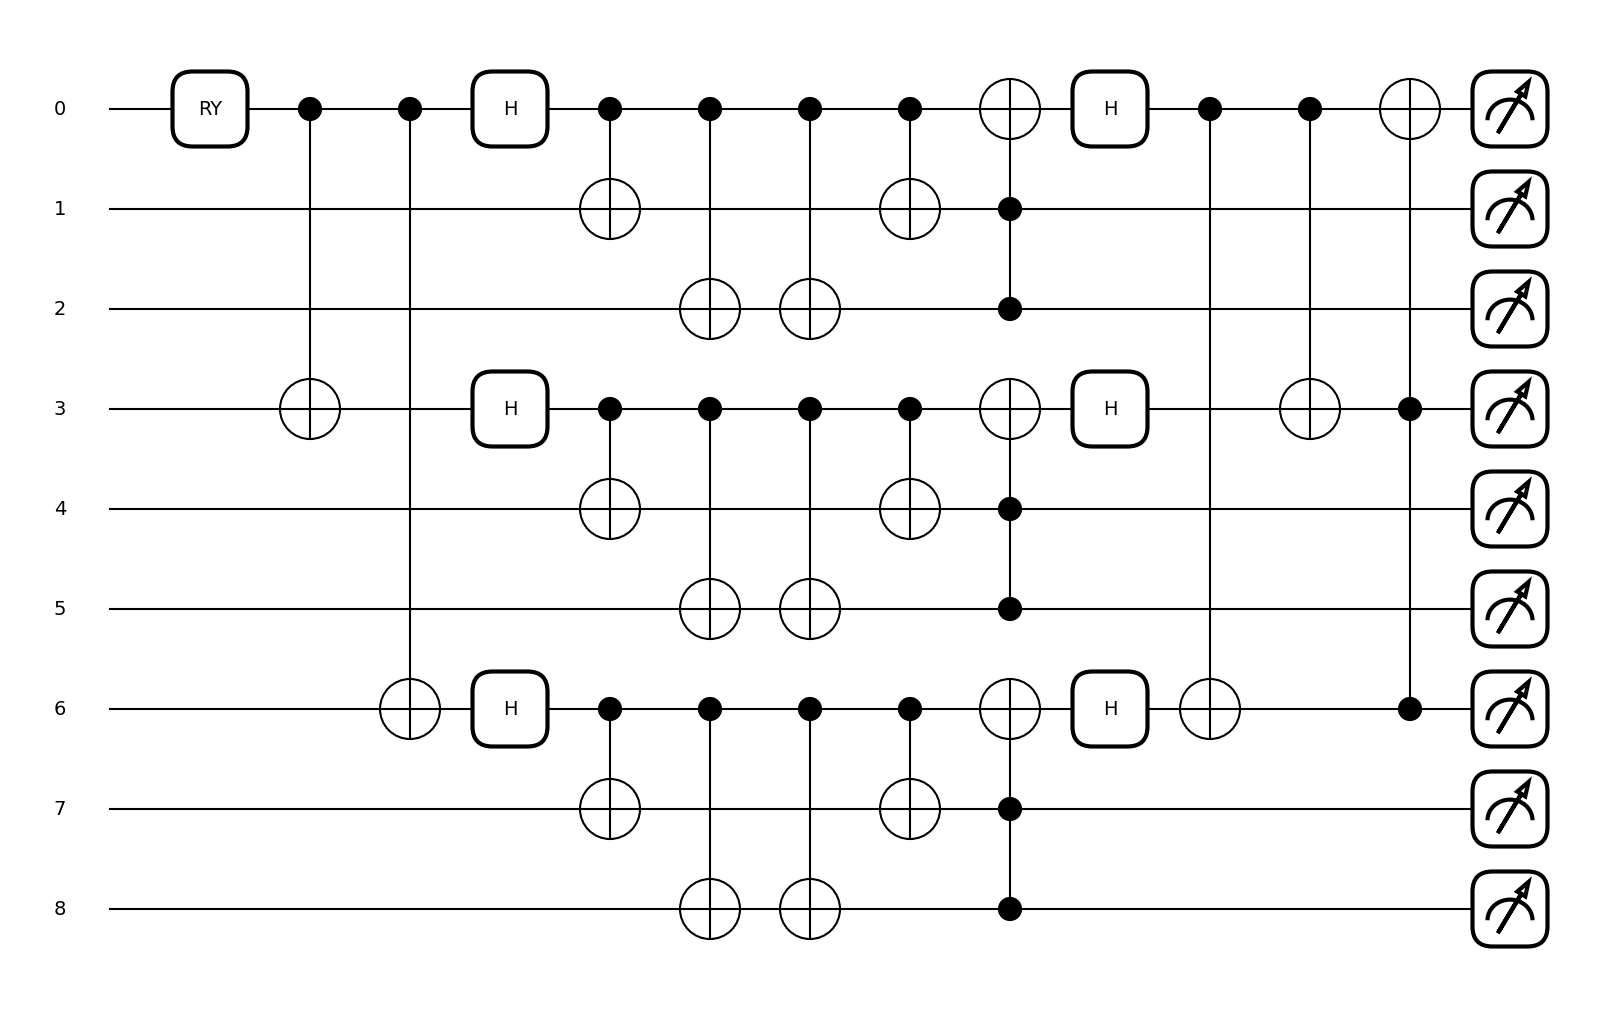

In [16]:
qml.draw_mpl(shor_code)()

In [17]:
qml.math.partial_trace(shor_code(4, 5), indices=list(range(1, 9)))

array([[0.75     +0.j, 0.4330127+0.j],
       [0.4330127+0.j, 0.25     +0.j]])